In [1]:
import numpy as np
import pandas as pd
import csv
import struct
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras

In [2]:
# reading and additional functions

# define moving average function
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

# check exist date in roti date array
def exist_date_roti(roti_date, date_check):
    for date_r in roti_date:
        if date_check[0] == date_r[0] and date_check[1] == date_r[1] and date_check[2] == date_r[2]:
            return True
    return False

# convert doy in normal date with day and month
def doy2day(doy, year):
    startDate = datetime(year=year, month=1, day=1)
    daysToShift = doy - 1
    endDate = startDate + timedelta(days=daysToShift)
    
    month = endDate.month
    day = endDate.day
    
    return day, month

def read_roti(filename):
    with open(filename, 'rb') as f:
        header_read = False
        date = None
        lats = []
        rows = []
        date_arr = []
        line = f.readline()
        while not header_read or (line.strip() and not line.strip().startswith(b"END OF ROTIPOLARMAP")):
            if line.strip().startswith(b"START OF ROTIPOLARMAP"):
                header_read = True
            elif line.strip().startswith(b"END OF ROTIPOLARMAP") or line.strip().startswith(b"END OF FILE"):
                break
            elif not header_read:
                pass
            elif line[0:5].strip():
                date = datetime(int(line[0:7]), int(line[7:14]), int(line[14:21]))
                year = int(line[0:7])
                month = int(line[7:14])
                day = int(line[14:21])
                
                date_arr.append(day)
                date_arr.append(month)
                date_arr.append(year)
            else:
                lat, lon_start, lon_end = float(line[3:9]), float(line[9:15]), float(line[15:21])
                lats.append(lat)

                block = [f.readline() for _ in range(18)]
                row = np.genfromtxt(block)
                rows.append(row.ravel())
            line = f.readline()
        return date, np.array(lats), np.array(date_arr), np.array(rows)

def get_array_roti():
    maps = []
    map_date = []
    for year in range(10, 21, 1):
        for doy in range(1, 367, 1):
            if doy > 295 and year == 20:
                break
            daily_lats = []
            daily_date = []
            daily_map = []
            
            if len(str(doy)) == 1:
                doy_str = "00" + str(doy)
            elif len(str(doy)) == 2:
                doy_str = "0" + str(doy)
            else:
                doy_str = str(doy)
            filename = '../data/roti/2010-2020/roti' + doy_str + '0.' + str(year) + 'f'
            try:
                date, daily_lats, daily_date, daily_map = read_roti(filename)
            except FileNotFoundError:
                continue
            else:
                date, daily_lats, daily_date, daily_map = read_roti(filename)

            map_date.append(daily_date)
            maps.append(daily_map)

    return np.array(map_date), np.array(maps)

def read_dst(filename, roti_date):
    with open(filename, 'r') as f:
        dst_arr = []
        dst_mean_arr = []
        dst_date = []

        day = 0
        month = 0
        year = 0

        while day != 21 or month != 10 or year != 2020:
            dst_daily = []
            date = []

            line = f.readline()

            year = int(2000 + int(line[3:5]))
            month = int(line[5:7])
            day = int(line[8:10])
                
            date.append(day)
            date.append(month)
            date.append(year)
            
            if not exist_date_roti(roti_date, date):
                continue

            dst_date.append(date)

            if len(line) > 121:
                index_string = line[21:len(line)]
            else:
                index_string = line[21:120]

            index_value = index_string.split()
            for value in index_value:
                val = float(value)
                dst_daily.append(val)

            dst_mean = dst_daily[-1]
            dst_daily.pop(-1)
            dst_arr.append(dst_daily)
            dst_mean_arr.append(dst_mean)
        
        return np.array(dst_arr), np.array(dst_date), np.array(dst_mean_arr)

def add_special_date_f107(day, month, year, f107_arr, f107_date):
    f107_daily = []
    date = []
    if year == 2011:
        value = 90.1
    elif year == 2012:
        value = 131.75
    elif year == 2015:
        value = 148.8
    elif year == 2020:
        value = 72.93
    f107_daily.append(value)
    f107_arr.append(f107_daily)
    date.append(day)
    date.append(month)
    date.append(year)
    f107_date.append(date)
    return f107_arr, f107_date

def read_f107(filename, roti_date):
    with open(filename, 'rb') as f:
        f107_arr = []
        f107_date = []
        day = 0
        month = 0
        year = 0
        
        # we should skip 2 lines in file bc it is head of file
        line = f.readline()
        line = f.readline()

        start_indx = 0
        sum_siblings = 0
        f107_obs_sum = 0

        while day != 22 or month != 10 or year != 2020:
            f107_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])
            
            if year < 2010:
                continue
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            if start_indx == 0:
                start_date = date
                start_indx = 1

            f107_obs = float(line[53:63])

            if start_date[0] != date[0] or start_date[1] != date[1] or start_date[2] != date[2]:
                f107_date.append(start_date)
                if sum_siblings == 1:
                    value = f107_obs_sum / 2
                elif sum_siblings == 2:
                    value = f107_obs_sum / 3
                elif sum_siblings == 3:
                    value = f107_obs_sum / 4
                else:
                    value = f107_obs
                f107_daily.append(value)
                f107_arr.append(f107_daily)
                sum_siblings = 0
                f107_obs_sum = 0
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2010:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2011, f107_arr, f107_date)
                if start_date[0] == 31 and start_date[1] == 12 and start_date[2] == 2011:
                    f107_arr, f107_date = add_special_date_f107(1, 1, 2012, f107_arr, f107_date)
                if start_date[0] == 12 and start_date[1] == 1 and start_date[2] == 2015:
                    f107_arr, f107_date = add_special_date_f107(13, 1, 2015, f107_arr, f107_date)
                if start_date[0] == 20 and start_date[1] == 10 and start_date[2] == 2020:
                    f107_arr, f107_date = add_special_date_f107(21, 10, 2020, f107_arr, f107_date)
                start_date = date
            else:
                f107_obs_sum += f107_obs
                sum_siblings += 1

        return np.array(f107_arr), np.array(f107_date)

def read_bz_sw(filename, roti_date):
    with open(filename, 'rb') as f:
        bz_arr = []
        bz_date = []
        sw_arr = []
        sw_date = []
        
        day = 0
        month = 0
        year = 0
        
        while day != 21 or month != 10 or year != 2020:
            bz_daily = []
            sw_daily = []
            date = []
            
            line = f.readline()
            
            year = int(line[0:4])
            doy = int(line[5:8])
            day, month = doy2day(doy, year)
            
            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue
            
            bz_sw_string = line[18:len(line)]
            bz_sw_value = bz_sw_string.split()
            
            bz_date.append(date)
            sw_date.append(date)
            
            for i in range(3):
                if i == 0:
                    bz_daily.append(float(bz_sw_value[i].decode()))
                else:
                    sw_daily.append(float(bz_sw_value[i].decode()))
            
            bz_arr.append(bz_daily)
            sw_arr.append(sw_daily)
        
    return np.array(bz_arr), np.array(bz_date), np.array(sw_arr), np.array(sw_date)

def read_kp(filename, roti_date):
    with open(filename, 'rb') as f:
        kp_arr = []
        kp_date = []
        
        day = 0
        month = 0
        year = 0

        # we should skip first line in file bc it is head of file
        line = f.readline()
        
        while day != 21 or month != 10 or year != 2020:
            kp_daily = []
            date = []

            line = f.readline()

            year = int(line[0:4])
            month = int(line[4:6])
            day = int(line[6:8])

            date.append(day)
            date.append(month)
            date.append(year)

            if not exist_date_roti(roti_date, date):
                continue

            kp_date.append(date)

            kp_str = str(line[25:28].decode())
            
            if kp_str[len(kp_str) - 1] == '+':
                kp_value = float(kp_str[:len(kp_str) - 1]) + 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            elif kp_str[len(kp_str) - 1] == '-':
                kp_value = float(kp_str[:len(kp_str) - 1]) - 1/3
                kp_value = float("{0:.2f}".format(kp_value))
            else:
                kp_value = float(kp_str)

            kp_daily.append(kp_value)
            kp_arr.append(kp_daily)
            
        return np.array(kp_arr), np.array(kp_date)


In [3]:
# plotting functions

def plot_data_roti(date, lons, lats, map):
    lons, lats = np.meshgrid(lons, lats)

    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection='polar')
    levels = np.arange(0, 0.6, 0.1)
    cc = ax.contourf(np.deg2rad(lons), 90. - lats, map, levels=levels, extend='both')

    plt.title("ROTI index date: " + str(date))

    plt.colorbar(cc, ax=ax, label="ROTI, TECU/min")

    mlt = np.linspace(0, 24, 49)

    plt.show()

def plot_sw_index(date, array_data, name_index):
    fig_prot = plt.figure()
    ax_prot = fig_prot.add_subplot(111)

    fig_pls = plt.figure()
    ax_pls = fig_pls.add_subplot(111)

    prot = []
    pls = []

    data_month_prot = []
    data_month_pls = []
    month_line_prot = []
    month_line_pls = []

    if name_index == 'Solar Wind':
        for item in array_data:
            prot.append(item[0])
            pls.append(item[1])

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month_prot.append(np.mean(prot[i - 30: i]))
            data_month_pls.append(np.mean(pls[i - 30: i]))
            month_line_prot.append(i - 30 / 2)
            month_line_pls.append(i - 30 / 2)

    data_avg_prot = moving_avg(prot, 400)
    data_avg_plasm = moving_avg(pls, 400)
    data_avg_prot.reshape(len(data_avg_prot), 1)
    data_avg_plasm.reshape(len(data_avg_plasm), 1)
    step = len(prot) / len(data_avg_prot)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg_prot), 1)

    ax_pls.set_title('Data index Plasma Speed, km/s')
    ax_pls.set_xlabel('Days', size=12)
    ax_pls.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_pls.plot(month_line_pls, data_month_pls, label='Month')
    ax_pls.plot(day_avg, data_avg_plasm, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_pls.legend(loc='upper left')

    ax_prot.set_title('Data index Proton Density, N/cm^3')
    ax_prot.set_ylim(0, 20)
    ax_prot.set_xlabel('Days', size=12)
    ax_prot.set_ylabel(name_index, size=12)
    # ax.plot(day_line, array_data, label='Day')
    ax_prot.plot(month_line_prot, data_month_prot, label='Month')
    ax_prot.plot(day_avg, data_avg_prot, color='red', label='Avg-400')
    # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
    ax_prot.legend(loc='upper left')

    plt.show()

def plot_data_index(date, array_data, name_index):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    data_month = []
    month_line = []

    data_half_year = []
    half_year_line = []

    data_year = []
    year_line = []

    day_line = np.arange(0, len(date), 1).reshape(len(array_data), 1)

    for i in range(len(array_data)):
        if i % 30 == 0:
            data_month.append(np.mean(array_data[i - 30: i]))
            month_line.append(i - 30 / 2)

    for i in range(len(array_data)):
        if i % 180 == 0:
            data_half_year.append(np.mean(array_data[i - 180: i]))
            half_year_line.append(i - 180 / 2)
    
    data_avg = moving_avg(array_data, 400)
    data_avg.reshape(len(data_avg), 1)
    step = len(array_data) / len(data_avg)
    day_avg = np.arange(0, len(date), step).reshape(len(data_avg), 1)

    ax.set_title('Data index ' + name_index)
    ax.set_xlabel('Days', size=12)
    ax.set_ylabel(name_index, size=12)

    match name_index:
        case 'Flux 10-7':
            ax.plot(month_line, data_month, label='Month')
            ax.plot(half_year_line, data_half_year, label='Half-year')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(year_line, data_year, color='black', label='Year')
            ax.legend(loc='upper left')
        case 'Imf-Bz':
            # ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
        case _:
            ax.plot(day_line, array_data, label='Day')
            ax.plot(month_line, data_month, label='Month')
            ax.plot(day_avg, data_avg, color='red', label='Avg-400')
            # ax.plot(half_year_line, data_half_year, color='black', label='Half-year')
            ax.legend(loc='upper left')
    plt.show()

In [4]:
# roti data and date
roti_map_date = []
roti_maps = []
roti_map_date, roti_maps = get_array_roti()

In [5]:
# data
# kp_data, bz_data, sw_data, f107_data, dst_data

kp_file = '../data/kp/Kp_index.txt'
kp_arr, kp_date = read_kp(kp_file, roti_map_date)

bz_sw_file = '../data/imfbz_sw/omni2_daily_Wxi8tQda3U.lst.txt'
bz_arr, bz_date, sw_arr, sw_date = read_bz_sw(bz_sw_file, roti_map_date)

f107_file = '../data/f10-7/fluxtable.txt'
f107_arr, f107_date = read_f107(f107_file, roti_map_date)

dst_file = '../data/dst/WWW_dstae03359771.dat.txt'
dst_arr, dst_date, dst_mean_arr = read_dst(dst_file, roti_map_date)

In [6]:
# shape of data
print("shape kp data ", kp_arr.shape)
print("shape kp date line ", kp_date.shape)
print("shape bz data ", bz_arr.shape)
print("shape bz date line ", bz_date.shape)
print("shape sw data ", sw_arr.shape)
print("shape sw date line ", sw_date.shape, "\n")
print("shape f10-7 data ", f107_arr.shape)
print("shape f10-7 date line ", f107_date.shape, "\n")
print("shape dst data ", dst_arr.shape)
print("shape dst data mean", dst_mean_arr.shape)
print("shape dst date line ", dst_date.shape, "\n")
roti_maps_reshape = roti_maps.reshape(3935, 3600)
print("shape roti data ", roti_maps.shape)
print("shape roti data reshape", roti_maps_reshape.shape)
print("shape roti date line ", roti_map_date.shape)

shape kp data  (3935, 1)
shape kp date line  (3935, 3)
shape bz data  (3935, 1)
shape bz date line  (3935, 3)
shape sw data  (3935, 2)
shape sw date line  (3935, 3) 

shape f10-7 data  (3935, 1)
shape f10-7 date line  (3935, 3) 

shape dst data  (3935, 24)
shape dst data mean (3935,)
shape dst date line  (3935, 3) 

shape roti data  (3935, 20, 180)
shape roti data reshape (3935, 3600)
shape roti date line  (3935, 3)


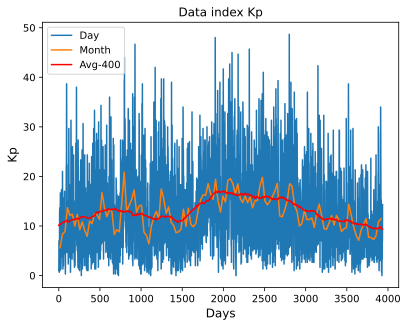

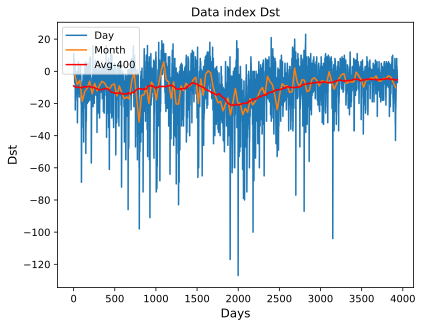

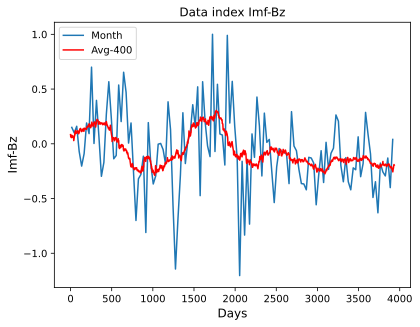

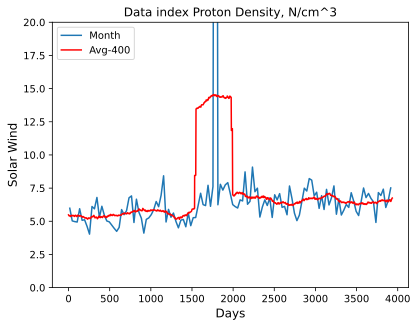

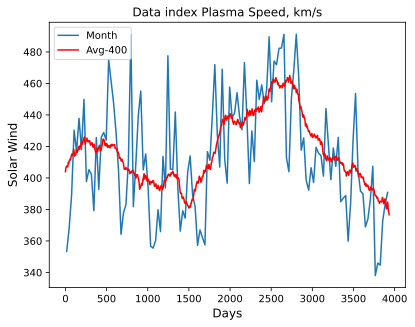

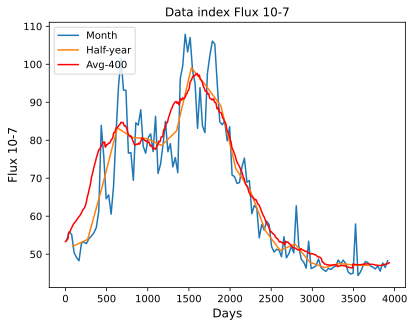

In [7]:
# analyze graphs

plot_data_index(kp_date, kp_arr, 'Kp')
plot_data_index(dst_date, dst_mean_arr, 'Dst')
plot_data_index(bz_date, bz_arr, 'Imf-Bz')
plot_sw_index(sw_date, sw_arr, 'Solar Wind')
# plot_f107_index(f107_date, f107_arr, 'Flux 10-7')
plot_data_index(f107_date, f107_arr, 'Flux 10-7')

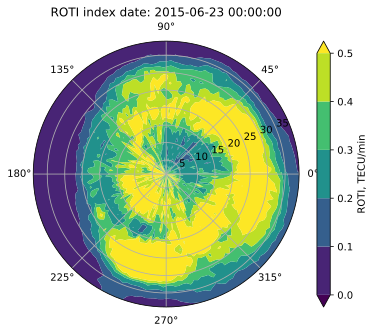

In [8]:
# example of ROTI map

# doy = ["020", "021", "022", "023", "024"]
doy = ["174"]
all_maps = []

for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)


Всего данных - 3935. Будем использовать 86% данных для тренировки сети, 2,5% для валидации и оставшиеся 2,5% для теста:
```
- train_data - 3735
- val_data - 100
- test_data - 100
```

Также необходимо провести нормировку всех данных, кроме карт ROTI, поскольку они уже изначально имеют значения в диапазоне (0;1)

In [9]:
# Normalize data
train_num = 3735

def mean_data(data):
    mean = data[:].mean(axis=0)
    data -= mean
    std = data[:].std(axis=0)
    data /= std
    return data

kp_data = mean_data(kp_arr)
bz_data = mean_data(bz_arr)
f107_data = mean_data(f107_arr)
dst_data = mean_data(dst_arr)
sw_data = mean_data(sw_arr)

Соберем данные индексов в единый массив со следующей индексацией:
- 0 : KP index
- 1 : BZ index
- 2 : SW Proton Density
- 3 : SW Plasma Speed
- 4 : F10-7
- 5-28 : DST index

In [10]:
def accumulate_indexes(kp_data, bz_data, sw_data, f107_data, dst_data):
    all_indexes = []
    for i in range(len(kp_data)):
        indexes = []
        indexes.append(kp_data[i][0])
        indexes.append(bz_data[i][0])
        indexes.append(sw_data[i][0])
        indexes.append(sw_data[i][1])
        indexes.append(f107_data[i][0])
        for j in range(24):
            indexes.append(dst_data[i][j])
        all_indexes.append(indexes)
    return np.array(all_indexes)

all_indexes = []
all_indexes = accumulate_indexes(kp_data, bz_data, sw_data, f107_data, dst_data)
all_indexes.shape

(3935, 29)

##### Generation sample-targets lists function
- **data_indexes** — исходный массив вещественных чисел - *all_indexes*
- **roti_data** - преобразованный массив карт ROTI, который будет исполльзоваться в качестве целевых данных - *roti_maps_reshape*
- **lookback** — количество интервалов в прошлом от заданного момента, за которое отбираются входные данные - 5 дней
- **delay** — количество интервалов в будущем от заданного момента, за которое отбираются целевые данные - 1 день. Данный параметр применяется к картам ROTI
- **min_index** и **max_index** — индексы в массиве data, ограничивающие область для извлечения данных; это помогает оставить в неприкосновенности сегменты проверочных и контрольных данных
- **shuffle** — флаг, определяющий порядок извлечения образцов: с перемешиванием или в хронологическом порядке
- **batch_size** — количество образцов в пакете - 32
- **step** — период в интервалах, из которого извлекается один образец - 1

In [15]:
# Generation sample-targets lists function

def generator(data_indexes, roti_data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=1):
    if max_index is None:
        max_index = len(data_indexes) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data_indexes.shape[-1]))
        targets = np.zeros((len(roti_data[0]),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data_indexes[indices]
            # targets[j] = data_indexes[rows[j] + delay][1]
        targets = roti_data[i + delay]
        targets = targets.reshape(60, 60)
        yield samples, targets

In [72]:
# Creating x_train, y_train data function

def Get_train_data(data_indexes, roti_map, kp_date, lookback, shuffle=False):
    x_train = []
    y_train = []
    y_date = []
    x_test = []
    y_test = []

    # if not shuffle:
    #     start = min_index
    for i in range(5000):
        train = []
        if shuffle:
            start = np.random.randint(0, train_num)
        for j in range(lookback):
            for item in range(len(data_indexes[1])):
                train.append(data_indexes[start + j][item])
            for item in range(len(roti_map[1])):
                train.append(roti_map[start + j][item])
            # x_train.append(data_indexes[start + j])
            # x_train.append(roti_map[start + j])
        x_train.append(train)
        y_train.append(roti_map[start + lookback])
        y_date.append(kp_date[start + lookback])
        # if not shuffle:
        #     start += 1
    for i in range(200 - lookback):
        test = []
        for j in range(lookback):
            for item in range(len(data_indexes[1])):
                test.append(data_indexes[train_num + i + j][item])
            for item in range(len(roti_map[1])):
                test.append(roti_map[train_num + i + j][item])
        x_test.append(test)
        y_test.append(roti_map[train_num + i + lookback])
    return np.array(x_train), np.array(y_train), np.array(y_date), np.array(x_test), np.array(y_test)

lookback = 3
# print(len(all_indexes[::-1]))
x_train, y_train, y_date, x_test, y_test = Get_train_data(all_indexes, roti_maps_reshape, kp_date, lookback, shuffle=True)
# x_train = x_train.reshape(5000, 10887)
# x_test = x_test.reshape(196, 87)

x_val = x_test[-100:]
y_val = y_test[-100:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# print("roti")
# for item in roti_maps_reshape:
#     print(item)
# print("\n\n\ntrain")
# for item in y_train:
#     print(item)

(5000, 10887)
(5000, 3600)
(197, 10887)
(197, 3600)


In [12]:
# lookback = 3
# step = 1
# delay = 1
# batch_size = 60

# train_gen = generator(all_indexes,
#  roti_maps_reshape,
#  lookback=lookback,
#  delay=delay,
#  min_index=0,
#  max_index=3735,
#  shuffle=True,
#  step=step,
#  batch_size=batch_size)
# val_gen = generator(all_indexes,
#  roti_maps_reshape,
#  lookback=lookback,
#  delay=delay,
#  min_index=3736,
#  max_index=3835,
#  step=step,
#  batch_size=batch_size)
# test_gen = generator(all_indexes,
#  roti_maps_reshape,
#  lookback=lookback,
#  delay=delay,
#  min_index=3836,
#  max_index=None,
#  step=step,
#  batch_size=batch_size)

# # Сколько раз нужно обратиться к val_gen, чтобы получить проверочный набор данных целиком
# val_steps = (3835 - 3736 - lookback) // batch_size

# # Сколько раз нужно обратиться к test_gen gen, чтобы получить контрольный набор данных целиком
# test_steps = (len(all_indexes) - 3836 - lookback) // batch_size


In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam

In [94]:
input_shape = (24, 10887)
print(input_shape[1:])

model = tf.keras.Sequential()
model.add(layers.Dense(10887, activation='tanh'))
# model.add(layers.Conv1D(64, 5, activation='relu', input_shape=input_shape[1:]))
# model.add(layers.Conv1D(64, 5, activation='relu', input_shape=(None, 24,)))
# model.add(layers.MaxPooling1D(2))
# model.add(layers.Dense(20000, kernel_regularizer='l1', activation='tanh'))
model.add(layers.LSTM(128,
 dropout=0.1,
 recurrent_dropout=0.4,
 return_sequences=True,))
model.add(layers.LSTM(64,
 dropout=0.2,
 recurrent_dropout=0.5,))
model.add(layers.Dense(1800, activation='relu'))
model.add(layers.Dense(3600))
# model.add(layers.Dense(5000, kernel_regularizer='l1', activation='relu'))
# model.add(layers.Dense(3600))
model.compile(optimizer=Adam(), loss='mae', metrics=['accuracy'])
history = model.fit(x_train, y_train,
 batch_size=24,
 steps_per_epoch=10,
 epochs=10,
 validation_data=(x_val, y_val),
 )
model.summary()

print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=10)
print("test loss, test acc:", results)

(10887,)
Epoch 1/10


ValueError: in user code:

    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_53" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_50" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 10887)
    
    Call arguments received by layer "sequential_53" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 10887), dtype=float32)
      • training=True
      • mask=None


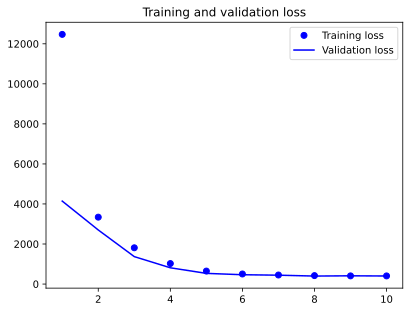

In [75]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 97ms/step
[[  10    7 2012]]
predictions shape: (1, 3600)


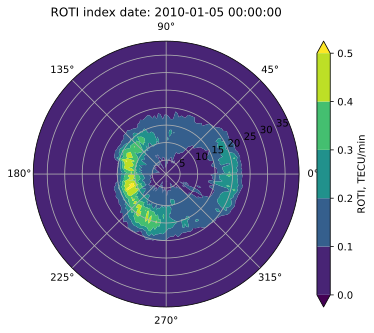

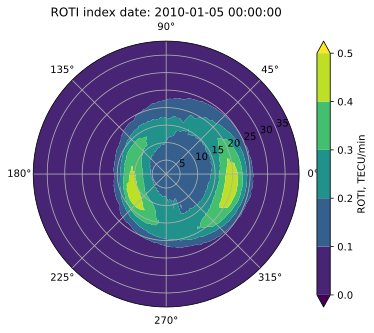

In [76]:
predictions = model.predict(x_test[:1])
date = y_date[:1]
print(date)
print("predictions shape:", predictions.shape)
doy = ["005"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.10f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = predictions.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

1/1 [==============================] - 0s 57ms/step
[[   4    7 2015]]
predictions shape: (1, 3600)


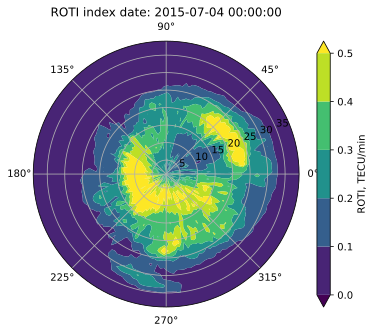

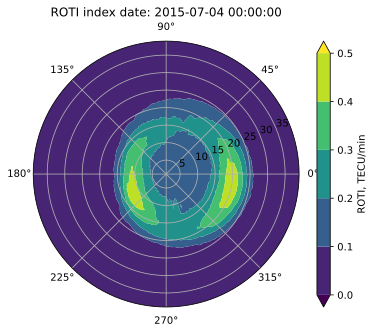

In [78]:
predictions = model.predict(x_test[35:36])
date = y_date[35:36]
print(date)
print("predictions shape:", predictions.shape)
doy = ["185"]
for day in doy:
    filename = '../data/roti/2010-2020/roti' + day + '0.15f'

    lats = []
    rows = []
    date_map = []
    all_maps = []

    date, lats, date_map, map = read_roti(filename)

    all_maps.append(map)
    all_map = np.mean(all_maps, axis=0)
    # print("all_map:\n", all_map.shape[1])
    lons = np.linspace(1, 361, all_map.shape[1])
    # lons = np.linspace(1, 361, 180)
    plot_data_roti(date, lons, lats, map)
    map = predictions.reshape(20, 180)
    plot_data_roti(date, lons, lats, map)

In [13]:
# Simple Neural Network creating

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, all_indexes.shape[-1])))
model.add(layers.Dense(200, activation='softmax'))
model.add(layers.Dense(300, activation='softmax'))
model.add(layers.Dense(60))
# model.summary()
# model.compile(optimizer=RMSprop(), loss='mae')
# history = model.fit_generator(train_gen,
#  steps_per_epoch=500,
#  epochs=20,
#  validation_data=val_gen,
#  validation_steps=val_steps)
model.compile(optimizer=Adam(), loss='mae', metrics=['accuracy'])
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=20,
 validation_data=val_gen,
 validation_steps=val_steps)

NameError: name 'Sequential' is not defined

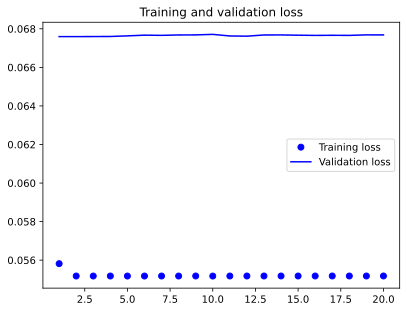

In [130]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [131]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=test_steps, verbose=2)
print('test_loss: ', test_loss)
print('test_acc: ', test_acc)

1/1 - 0s - loss: 0.0570 - accuracy: 0.0333 - 16ms/epoch - 16ms/step
test_loss:  0.056996170431375504
test_acc:  0.03333333507180214


In [84]:
# Recurrent Neural Network creating with GRU layers

model = Sequential()
model.add(layers.GRU(145,
 dropout=0.1,
 recurrent_dropout=0.5,
 return_sequences=True,
 input_shape=(None, all_indexes.shape[-1])))
model.add(layers.GRU(200,
 dropout=0.2,
 recurrent_dropout=0.5,))
model.add(layers.Dense(200, activation='softmax'))
model.add(layers.Dense(180))
# model.summary()
model.compile(optimizer='adam', loss='mae')
history = model.fit_generator(train_gen,
 steps_per_epoch=500,
 epochs=20,
 validation_data=val_gen,
 validation_steps=val_steps)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, None, 145)         76560     
                                                                 
 gru_10 (GRU)                (None, 200)               208200    
                                                                 
 dense_59 (Dense)            (None, 200)               40200     
                                                                 
 dense_60 (Dense)            (None, 180)               36180     
                                                                 
Total params: 361,140
Trainable params: 361,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 11s 18ms/step - loss: 0.1313 - val_loss: 0.0444
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.

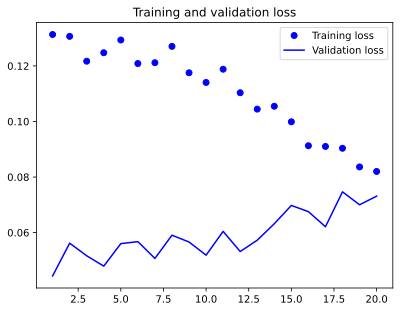

In [85]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [52]:
# Recurrent Neural Network with LSTM layers
print(x_train.shape[-1])

model = Sequential()
# model.add(layers.Dense(2088))
model.add(layers.LSTM(32,
 dropout=0.1,
 recurrent_dropout=0.4,
 return_sequences=True,))
model.add(layers.LSTM(64,
 dropout=0.2,
 recurrent_dropout=0.5,))
model.add(layers.Dense(1800, activation='relu'))
model.add(layers.Dense(3600))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['accuracy'])
history = model.fit(x_train, y_train,
 batch_size=24,
 steps_per_epoch=500,
 epochs=20,
 validation_data=(x_val, y_val),
 )

print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=10)
print("test loss, test acc:", results)

87
Epoch 1/20


ValueError: in user code:

    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.10/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_32" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_48" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2088)
    
    Call arguments received by layer "sequential_32" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 87), dtype=float32)
      • training=True
      • mask=None


In [35]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 200)               17600     
                                                                 
 dense_48 (Dense)            (None, 116)               23316     
                                                                 
 lstm_23 (LSTM)              multiple                  0 (unused)
                                                                 
 lstm_24 (LSTM)              multiple                  0 (unused)
                                                                 
 dense_49 (Dense)            multiple                  0 (unused)
                                                                 
 dense_50 (Dense)            multiple                  0 (unused)
                                                                 
Total params: 40,916
Trainable params: 40,916
Non-tra

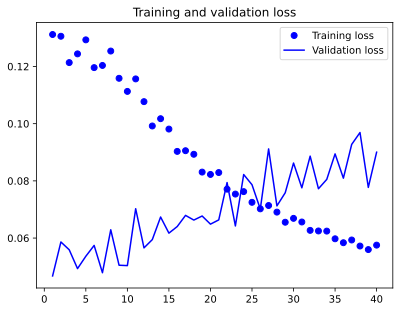

In [104]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [105]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=test_steps, verbose=2)
print('test_loss: ', test_loss)
print('test_acc: ', test_acc)

4/4 - 0s - loss: 0.0812 - accuracy: 0.0250 - 23ms/epoch - 6ms/step
test_loss:  0.08117689937353134
test_acc:  0.02500000037252903
